In [1]:
# Import required libraries
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


**D**ownloading data from Kaggle.com

In [2]:
# Getting data from kaggle.com
%%capture
# Keys for env - API
os.environ['KAGGLE_USERNAME'] = "karandeepbhardwaj" # username from the json file
os.environ['KAGGLE_KEY'] = "a188728f8e2873a3cd0394bd2b543ffb" # key from the json file

# Bash commands to download data and unzip in source directory
!kaggle datasets download -d andrewmvd/animal-faces
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip -d my_human_data
!unzip animal-faces.zip -d my_not_human_data
!rm -r sample_data
!rm animal-faces.zip
!rm face-mask-12k-images-dataset.zip
!mkdir "./my_human_data/Face Mask Dataset/Train/Mask/"
!mv "./my_human_data/Face Mask Dataset/Train/WithMask/" "./my_human_data/Face Mask Dataset/Train/Mask/"
!mkdir "./my_human_data/Face Mask Dataset/Train/NoMask/"
!mv "./my_human_data/Face Mask Dataset/Train/WithoutMask/" "./my_human_data/Face Mask Dataset/Train/NoMask/"
!mkdir "./my_not_human_data/afhq/train/NotHuman/"
!mv "./my_not_human_data/afhq/train/cat/" "./my_not_human_data/afhq/train/NotHuman/"

Paths to data folders created in source directory.

In [3]:
#Data Loading
classes = ['Masked', 'NotMasked', 'NotHuman']

maskPath = './my_human_data/Face Mask Dataset/Train/Mask/'
nonMaskPath = './my_human_data/Face Mask Dataset/Train/NoMask/'
nonHumanPath ='./my_not_human_data/afhq/train/NotHuman/'
directories = {0:maskPath, 1:nonMaskPath, 2:nonHumanPath}

**Data Extraction:** 
*   Extracting data from above defined paths.
*   Resizing Images.
*   Reading images from disk.
*   Writing to data as np array form to trainingData.


In [4]:
class PrepProcessingModel():
    IMAGESIZE = 100
    trainingData = []
    def makeDataSet(self):
        for label, dataDirectory in directories.items():
            print('\n\n Currently reading Label: ',label,'\n')
            for folder in tqdm(os.listdir(dataDirectory)):
                folderPath = os.path.join(dataDirectory, folder);
                for imgpath in os.listdir(folderPath):
                    imagePath = os.path.join(folderPath, imgpath);
                    img = cv2.imread(imagePath);
                    img = cv2.resize(img, (self.IMAGESIZE,self.IMAGESIZE));
                    self.trainingData.append([np.array(img), label]);
        np.random.shuffle(self.trainingData)

Running PreProcessing to write image marked data to trainingData.

In [5]:
PrepProcessingModel = PrepProcessingModel()
PrepProcessingModel.makeDataSet()
trainingData = PrepProcessingModel.trainingData

  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  0 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  1 



  0%|          | 0/1 [00:00<?, ?it/s]



 Currently reading Label:  2 



100%|██████████| 1/1 [00:20<00:00, 20.01s/it]


**An Example of Marked images along with labels:**

*  **Masked**

Masked


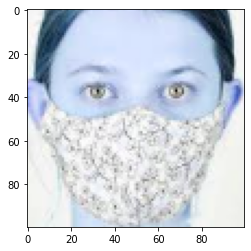

In [6]:
plt.imshow(trainingData[5][0]);
print(classes[trainingData[5][1]])

*  **Not Masked**

NotMasked


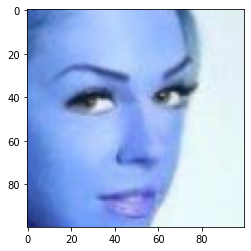

In [7]:
plt.imshow(trainingData[7008][0]);
print(classes[trainingData[7008][1]])

* **Not Human**

NotHuman


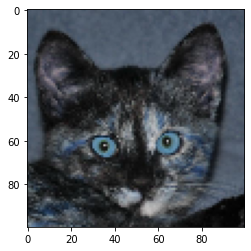

In [8]:
plt.imshow(trainingData[15056][0]);
print(classes[trainingData[15056][1]])

* **Creating Pytorch Dataset**

In [9]:
# Creating pytorch Dataset by converting training data set from preprocessing to tensor data type.
class BuildDataSet(Dataset):
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor(),
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]), torch.tensor(self.train_data[key][1])
            ]
        
        def __len__(self):
            return len(self.train_data)


> * Creating Training Data Loader
> * Creating validation Data Loader

In [10]:
myDataset = BuildDataSet(trainingData)
training_data, validation_data = torch.utils.data.random_split(myDataset, [(len(myDataset) - 1000), 1000])

batch_size = 32

train_dl = DataLoader(training_data, batch_size * 2, shuffle=True)
val_dl = DataLoader(validation_data, batch_size * 2)

# **Accuracy**

In [11]:
# Calculating accuracy from dataset
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    true_positives_negatives = torch.sum(preds == labels).item()
    total_predictions = len(preds)
    result = true_positives_negatives/total_predictions
    accuracy = torch.tensor(result)
    return accuracy

# **CNN** Architecture

In [12]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch 
        #Calculating Loss and Generating Predictions
        return F.cross_entropy(self(images), labels.long())
    
    def validation_step(self, batch):
        images, labels = batch
        #Calculating Loss and Generating Predictions
        return {'val_loss': F.cross_entropy(self(images), labels.long()).detach(),
                 'val_acc': accuracy(self(images), labels)}
        
    def validation_epoch_end(self, outputs):

        batchLosses = []
        batchAccuracies = []

        for x in outputs:
            batchLosses.append(x['val_loss'])
            batchAccuracies.append(x['val_acc'])

        epochLosses = torch.stack(batchLosses).mean()   # Combine losses
        epochAccuracies = torch.stack(batchAccuracies).mean()      # Combine accuracies

        return {'val_loss': epochLosses.item(), 'val_acc': epochAccuracies.item()}
    
    def epoch_end(self, epoch, result):

        print("Epoch: [{}]\nTraining Data Loss: {:.4f}\nValidation Data Loss: {:.4f}\nValidation data Accuracy: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class CNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            #First convolution layer
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),

            #Second convolution layer
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #First pooling layer
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            #Third convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            #Fourth convolution layer
            # nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),

            #Second pooling layer
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            #Flattening and rectification
            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3))
        
    def forward(self, xb):
      return self.network(xb)

**Checking the availability of GPU**
> If not present then use CPU

In [14]:
# Use GPU if available
device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
def toDevice(data, device):

    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        myList = []
        for x in data:
            myList.append(toDevice(x, device))
        return myList
    return data.to(device, non_blocking=True)

In [16]:
#Overriding Dataloader methods

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [18]:
#Training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)

In [19]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        # Training Phase 
        print('epoch: ', epoch)
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
# Model (on GPU)
model = CNNModel()
toDevice(model, device);
model.eval();

history = [evaluate(model, val_dl)]
history

history = fit(15, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch: [0]
Training Data Loss: 0.9108
Validation Data Loss: 0.6260
Validation data Accuracy: 0.7557
epoch:  1
Epoch: [1]
Training Data Loss: 0.3357
Validation Data Loss: 0.2923
Validation data Accuracy: 0.8922
epoch:  2
Epoch: [2]
Training Data Loss: 0.2124
Validation Data Loss: 0.2343
Validation data Accuracy: 0.9139
epoch:  3
Epoch: [3]
Training Data Loss: 0.1779
Validation Data Loss: 0.1320
Validation data Accuracy: 0.9553
epoch:  4
Epoch: [4]
Training Data Loss: 0.1480
Validation Data Loss: 0.1299
Validation data Accuracy: 0.9465
epoch:  5
Epoch: [5]
Training Data Loss: 0.1257
Validation Data Loss: 0.0905
Validation data Accuracy: 0.9682
epoch:  6
Epoch: [6]
Training Data Loss: 0.1140
Validation Data Loss: 0.1158
Validation data Accuracy: 0.9568
epoch:  7
Epoch: [7]
Training Data Loss: 0.0901
Validation Data Loss: 0.0771
Validation data Accuracy: 0.9746
epoch:  8
Epoch: [8]
Training Data Loss: 0.0829
Validation Data Loss: 0.0719
Validation data Accuracy: 0.9750
epoch:  9


In [21]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

#saving to disk
torch.save(model.state_dict(), './MaskDetection.pth')

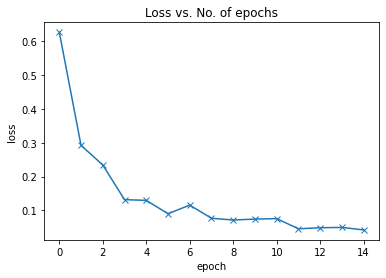

In [22]:
plot_losses(history)

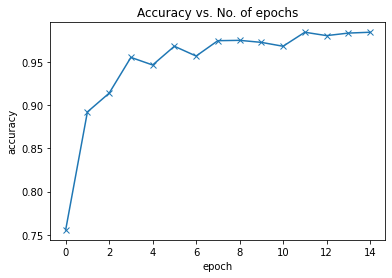

In [23]:
plot_accuracies(history)

In [24]:
# Testing
import matplotlib.image as mpimg

def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Image wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    
    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

In [25]:
        
def valImage(key, show = True):
    img = validation_data[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    cv2.imshow('',img.permute(1, 2,0), cmap=cm.bgr)
    print("predicted:",classes[preds.item()])
    print("Actual:",classes[validation_data[key][1]])

NotHuman
the image is :NotHuman


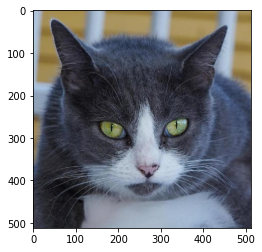

In [26]:
singleImage('./my_human_data/Face Mask Dataset/Test/WithMask/147.png', show=True)